In [66]:
import os
import random

import numpy as np
import pandas as pd
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [67]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [68]:
transform = torchvision.transforms.ToTensor()
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [69]:
sample, target, road_image, extra = iter(trainloader).next()

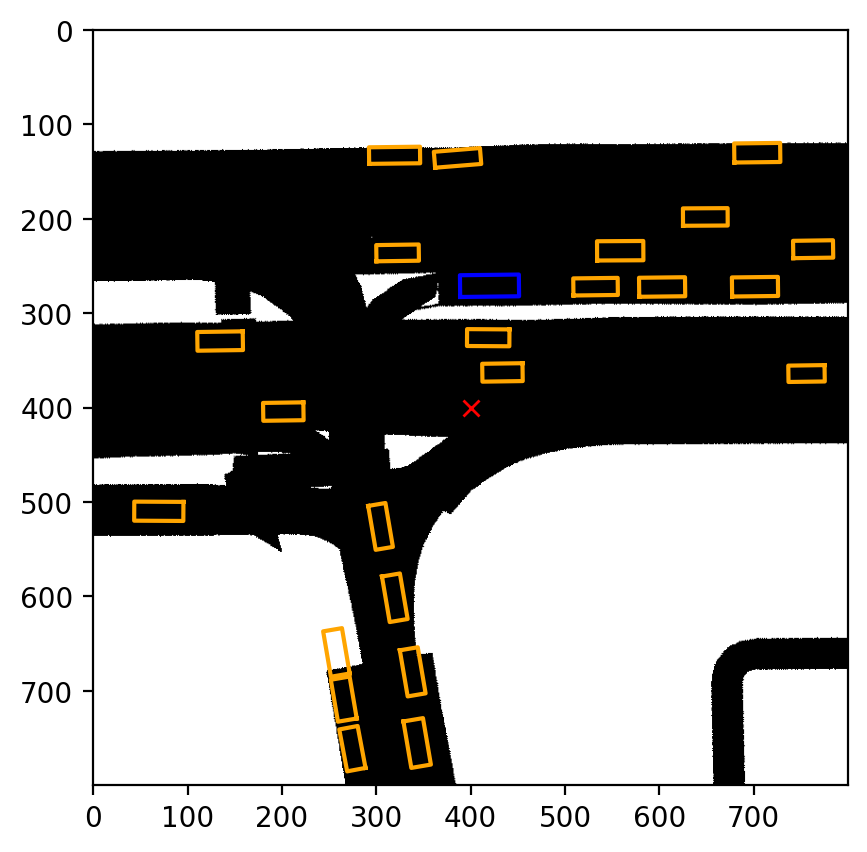

In [70]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])  

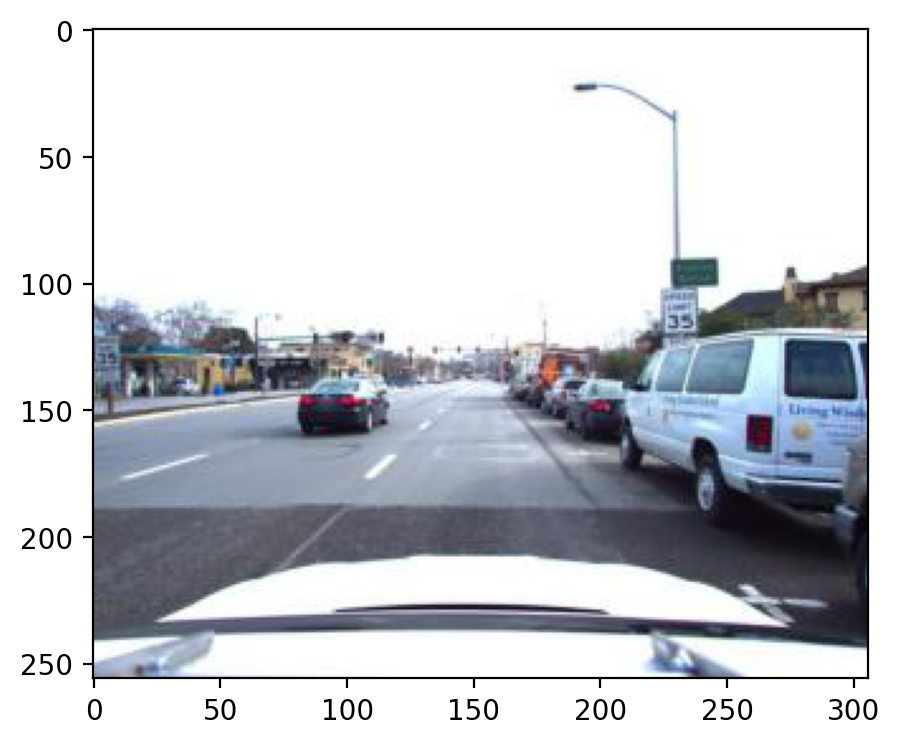

In [71]:
image = sample[1][1].numpy().transpose(1, 2, 0)
plt.imshow(image)

In [72]:
def is_front(bounding_boxes):
    mask = (abs(bounding_boxes[:,1]) <= bounding_boxes[:,0]*np.tan(np.radians(35))).numpy().any(1)
    new_points = bounding_boxes[mask]
    mask = (new_points[:,0] >= 0).all(1)
    new_points = new_points[mask]
    new_points[:,0] = 219-(new_points[:,0]/40)*219
    new_points[:,1] = (-new_points[:,1]+28)*(316/56)
    return new_points

(-0.5, 305.5, 203.5, -0.5)

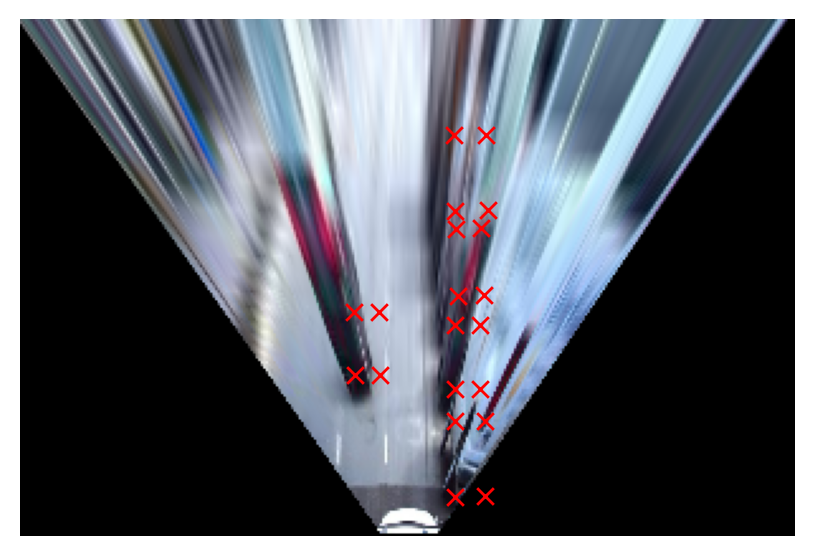

In [80]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
dst = np.float32(list(zip([142.9038,134.7327,163.4615,171.1431], [189.7793,167.3565,189.7793,167.3565])))
# dst = np.float32(list(zip([143.1000 , 134.9289 , 163.6577,171.3393], [189.7793 , 167.3565 , 189.7793 , 167.3565])))
# Keep Width,
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
# crop_img = img[y:y+h, x:x+w]
# cv2.imshow("cropped", crop_img)
warped_img = cv2.warpPerspective(image, M, (306,204))
fig, ax = plt.subplots()
ax.imshow(warped_img)
bounding_boxes = is_front(target[1]['bounding_box'])
# for corners in bounding_boxes:
#     point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
#     ax.plot(point_squence.T[0], point_squence.T[1])
# plt.scatter(np.array([149.05957 , 155.75008 , 148.478525, 155.16864 ]), np.array([[ 4.30992 ,  4.63842 , 27.060735, 27.389235]]))
# plt.scatter(np.array([140.389715, 148.13764 , 140.520855, 148.269175]), np.array([113.8378425, 113.75736  , 138.201045 , 138.1205625]))
plt.scatter(bounding_boxes[:,1],bounding_boxes[:,0], marker ='x', color = 'r', linewidth = 1)
plt.axis('off')

In [42]:
219

219

In [51]:
34*9

306

In [157]:
import pandas
targ = pd.read_csv(annotation_csv)
targ.head()

,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,fr_y,bl_y,br_y,category_id,action_id,new_scene
0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,21.132901,19.294995,21.173571,2,1,111
1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,31.026680,28.602180,30.464799,2,0,111
2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,-20.032588,-19.327417,-19.126877,3,2,111
3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,6.253638,8.090272,6.211696,2,1,111
4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,3.408720,5.245354,3.366778,2,1,111


In [202]:
from itertools import combinations

xs = list(zip(targ.fl_x,targ.fr_x,targ.bl_x,targ.bl_x))
x = []
for i in xs:
    i = combinations(i, 2)
    x.append(max([abs(j[0]-j[1]) for j in i]))
x = np.array(x)
ys = list(zip(targ.fl_y,targ.fr_y,targ.bl_y,targ.bl_y))
y = []
for i in ys:
    i = combinations(i, 2)
    y.append(max([abs(j[0]-j[1]) for j in i]))
y = np.array(y)

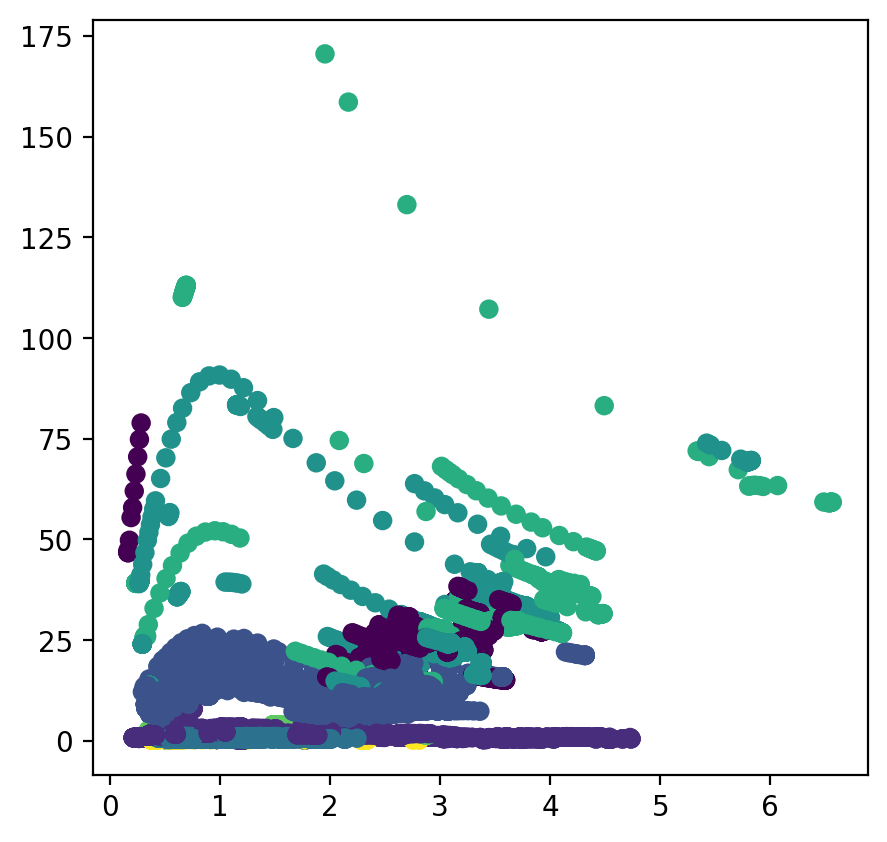

In [228]:
import matplotlib.pyplot as plt
plt.scatter(x/y,x*y, c=targ.category_id)

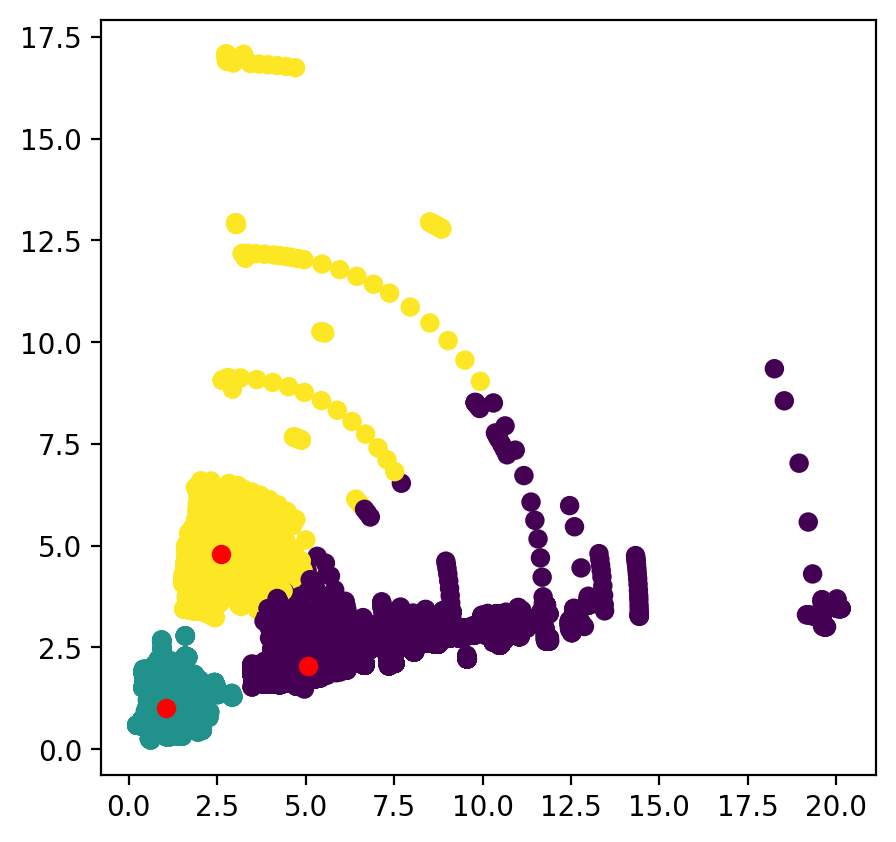

In [225]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array([[i,j] for i,j in zip(x,y)]))
plt.scatter(x,y, c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red')

In [226]:
kmeans.cluster_centers_

array([[5.07483691, 2.04436814],
       [1.06517383, 1.00428346],
       [2.61185785, 4.78781066]])

In [232]:
5:2
1:1
1:2

7.325670498084292